# Estimate pi with quantum

## with statevector and using angles from blochsphere

$$ |w> = \alpha|0> + \beta|1>, with |\alpha|^2 + |\beta|^2 = 1.$$
$$ |w> = cos(\theta/2)|0> + e^{i\phi}sin(\theta/2)|1> $$
$$=> for |w> = (-1,0), with \arccos => \pi $$

In [2]:
#imports
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit import Aer
from qiskit.utils import QuantumInstance

In [9]:
# construct state (-1,0)
qc = QuantumCircuit(1)
#qc.initialize([-1, 0], 0)
qc.x(0)
qc.z(0)
qc.x(0)
qc.draw()

┌───┐┌───┐┌───┐
q: ┤ X ├┤ Z ├┤ X ├
   └───┘└───┘└───┘

In [14]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator_statevector"), shots=1024)

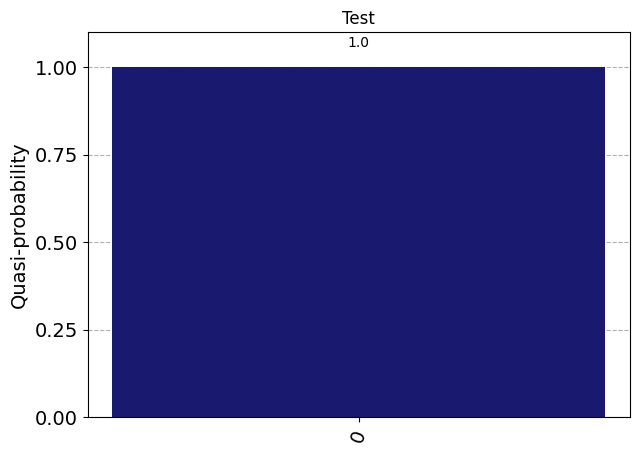

In [15]:
# test with one execution
from qiskit.tools.visualization import plot_histogram

result = quantum_instance.execute(qc)
plot_histogram(result.get_counts(), color='midnightblue', title="Test")

In [16]:
state_vector = result.get_statevector()

# Print the statevector
print(state_vector)

Statevector([-1.+1.2246468e-16j,  0.+0.0000000e+00j],
            dims=(2,))


In [17]:
my_pi = np.arccos(state_vector[0])
print(my_pi.real)

3.1415926425234173


In [18]:
#estimate error
print(my_pi.real - np.pi)

-1.1066375815715901e-08


## classical way

- use random numbers of x,y from [0...1]
- use equation $$ x^2 + y^2 <=1 $$
- repeat for num_shots time
-> as $$ r^2*\pi $$ being the area of the circle
-> with r==1 and x,y from [0...1] -> area = %%\pi/4 $$

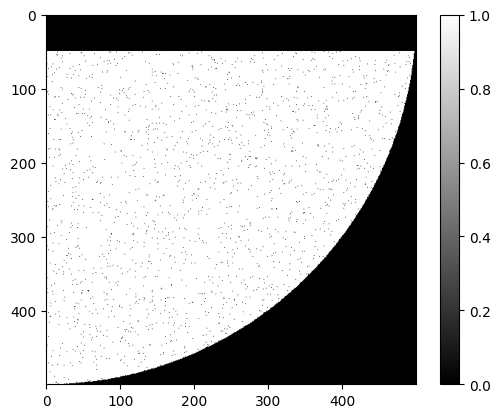

In [44]:
arr=np.zeros((500,500))

num_shots = 1024000
np.random.seed(42)

for i in range(num_shots):
    x = np.random.uniform(0,1)
    y = np.random.uniform(0.1)
    if np.sqrt(x**2 + y**2) <= 1.0:
        arr[int(y*500)][int(x*500)]=1.0
        
plt.imshow(arr, cmap='gray',vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [45]:
#now estimate pi
unique, counts = np.unique(arr, return_counts=True)

d = dict(zip(unique, counts))

print(d)

my_pi = 0.0
if 0.0 in d.keys() and 1.0 in d.keys():
    my_pi = d[1.0]/(500*500)*4

print(my_pi)

{0.0: 80183, 1.0: 169817}
2.717072


## pi with RX and RY gates...

In [46]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator_statevector"), shots=1024)

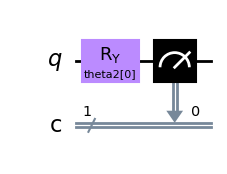

In [88]:
# quantum circuit
from qiskit.circuit import ParameterVector
theta2 = ParameterVector('theta2',length=1)

qc_radius = QuantumCircuit(1,1)
qc_radius.ry(theta2[0],0)

qc_radius.measure(0,0)
qc_radius.draw('mpl')

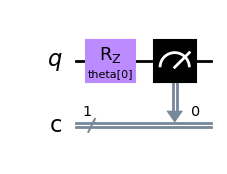

In [105]:
theta = ParameterVector('theta', length=1)
qc = QuantumCircuit(1,1)
qc.rz(theta[0],0)

qc.measure(0,0)
qc.draw('mpl')

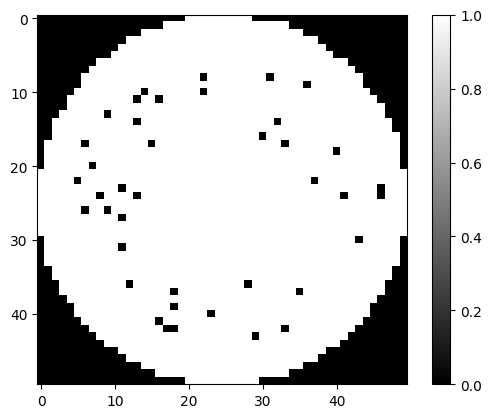

In [123]:
from qiskit.visualization import plot_bloch_multivector

num_shots = 1024
width = 50
height = width
num_retries = 100
num_radius = 75
np.random.seed(42)

arr=np.zeros((height,width))

for i in range(num_retries):
    #circle
    # bind parameters
    circuits = [qc.bind_parameters({theta: theta_val})
    for theta_val in [[i*(2*np.pi/num_retries)]]]
    #execute
    result = quantum_instance.execute(circuits[-1])
    # convert result
    state_vector = result.get_statevector()
    # Print the statevector
    #print(state_vector)
    
    for r in range(num_radius):
        # prepare circuit paramters
        #radius
        # bind parameters
        circuits_r = [qc_radius.bind_parameters({theta2: theta_val})
        for theta_val in [[r*(2*np.pi/num_radius)]]]
        #execute
        result = quantum_instance.execute(circuits_r[-1])
        # convert result
        #state_vector_r = result.get_statevector()
        #print(state_vector_r)
        if '0' in result.get_counts().keys():
            #shift so also negative radius is allowed (rz gate does not produce state of -|0> or -|1>)
            radius = (width - 1)*(num_shots/2 - result.get_counts()['0'])/num_shots
        else:
            radius = 0.0
        
        #print(radius) 
        
        x = width//2 + radius*state_vector[0].real
        y = height//2 + radius*state_vector[0].imag
        #print(x, " ", y)
        arr[int(y)][int(x)]=1.0
        
plt.imshow(arr, cmap='gray',vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [124]:
# now estimate pi by calculating ratio white to overall
# circle is (1/2*1)^2*pi -> pi = 4*circle
unique, counts = np.unique(arr, return_counts=True)

d = dict(zip(unique, counts))

print(d)

my_pi = 0.0
if 0.0 in d.keys() and 1.0 in d.keys():
    my_pi = d[1.0]/(width*height)*4

print(my_pi)

{0.0: 574, 1.0: 1926}
3.0816


In [19]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright